In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
from graphviz import Digraph
%matplotlib inline

In [3]:
xs = np.arange(-5,5,.25)
ys = f(xs)


print(xs)

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]


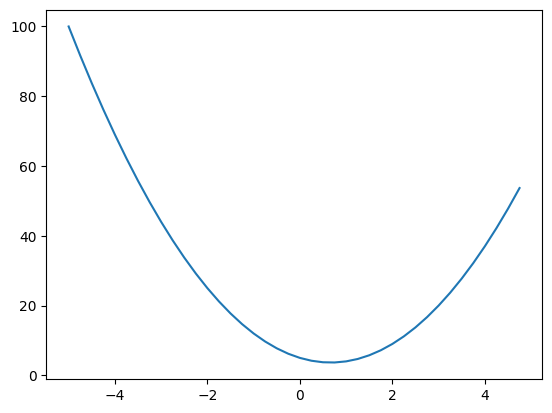

In [4]:
plt.plot(xs,ys)

In [5]:
def draw_nn(root):

  def trace(root):
    edges = set()
    nodes  =set ()

    def build(root):
      nodes.add(root)
      for child in root._prev:
        edges.add((child,root))
        build(child)

    build(root)

    return nodes,edges


  nodes, edges = trace(root)

  dot = Digraph(format = "svg",graph_attr={"rankdir":"LR"} )


  for n in nodes:

    uid = str(id(n))

    dot.node(name = uid,label = "{%s | data %.4f |grad %.4f}"%(n.label,n.data,n.grad),shape = "record")


    if(n._op!=''):

      dot.node(name = uid + str(id(n._op)),label = n._op)
      dot.edge(uid+str(id(n._op)),uid)


  for n1,n2 in edges:
      uid1 = str(id(n1))
      uid2 = str(id(n2))
      dot.edge(uid1,uid2+str(id(n2._op)))

  return dot


In [33]:
class Value():

  def __init__(self,data,_prev=(),_op='',label=''):

    self.data = data
    self._prev = _prev
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):

    return(f'Value(data={self.data,self.label})')

  def __add__(self,other):

    other =  other if isinstance(other,Value) else (Value(other))
    out = Value(self.data + other.data,(self,other),"+")

    def _backward():

      self.grad += out.grad
      other.grad += out.grad

    out._backward = _backward

    return out

  def __radd__(self,other):

    return self + other


  def __sub__(self,other):

    other = other if isinstance(other,Value) else (Value(other))

    out = Value(self.data - other.data,(self,other),"-")
    def _backward():

      self.grad += out.grad
      other.grad += out.grad

    out._backward = _backward

    return out

  def __rsub__(self,other):

    return self - other



  def __mul__(self,other):

    other =  other if isinstance(other,Value) else (Value(other))
    out = Value(self.data * other.data,(self,other),"*")

    def _backward():

      self.grad +=other.data*out.grad
      other.grad +=self.data*out.grad

    out._backward = _backward

    return out

  def __rmul__(self,other):

    return self*other


  def exp(self):

    out = Value((math.exp(self.data)),(self,),"exp")

    def _backward():
      self.grad += out.data*out.grad

    out._backward = _backward

    return out

  def __neg__(self):

    out = Value(-self.data)
    out.label = "-"+self.label

    def _backward():

      self.grad += self.grad

    out._backward = _backward
    return out


  def __pow__(self,other):

    out = Value((self.data**other),(self,), f"**{other}")

    def _backward():
      self.grad += other * (self.data**(other-1))*out.grad

    out._backward = _backward

    return out

  def __truediv__(self,other):

    out = self * other**-1
    out.label = "/"

    return out


  def tanh(self):

    x = self.data

    t = (math.exp(2*x) - 1)/ (math.exp(2*x) + 1)
    out = Value(t,(self,),"tanh")

    def _backward():

      self.grad += (1-t**2)*out.grad

    self._backward = _backward
    return out

  def relu(self):

    out = Value(max(0,self.data),(self,),"relu")

    def _backward():

        if(self.data<0):
          current_grad = 0
        else:
          current_grad = 1


        self.grad +=current_grad*out.grad

    self._backward = _backward
    return out

    pass

  def backward(self):

    self.grad = 1.0
    visited = set()

    def topological_sort(root):


      if root not in visited:
        root._backward()
        for child in root._prev:
          topological_sort(child)



    topological_sort(self)


In [34]:
a = Value(-2,label ="a")
b = Value(7,label = "b")
c = Value(4,label = "c")

In [35]:
temp = a.relu()
temp.backward()
# print(temp)

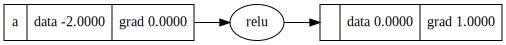

In [36]:
draw_nn(temp)

In [37]:
xx = a**2

In [38]:
xx

Value(data=(4, ''))

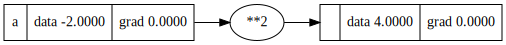

In [39]:
draw_nn(xx)

In [40]:
xx._prev

(Value(data=(-2, 'a')),)

In [41]:
k = a-2

In [42]:
l = -a +b

In [43]:
l.backward()

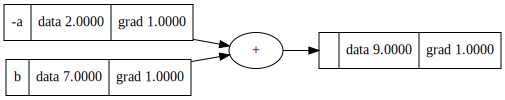

In [44]:
draw_nn(l)

In [45]:
d = a + b
d.label = "d"
h = d*c
h.label = "h"

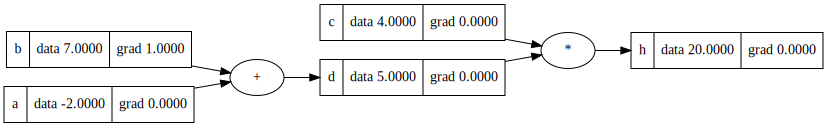

In [46]:
draw_nn(h)

In [47]:
h.backward()

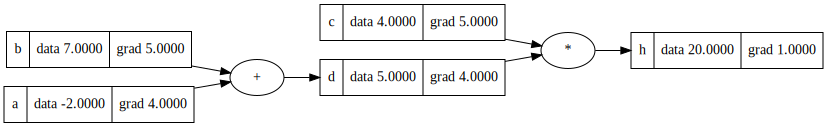

In [48]:
draw_nn(h)